In [1]:
import os
import pandas as pd
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import plotly.express as px
import json

os.chdir('../')


In [2]:

from Utils.SparkSessionManager import SparkSessionManager
from Service.DataReader import DataReader
from Service.VMAnalyzer import VMAnalyzer

In [3]:
spark = SparkSessionManager.create_session()
dt_reader = DataReader(spark)
with open('settings.json', 'r') as file:
    data = json.load(file)

local_settings = data['Local']
filepath = local_settings['filepath']
input_file = local_settings['input']

csv_file, vmSchema = dt_reader.read_data(filepath, input_file)
dt_analyzer = VMAnalyzer(spark, csv_file, vmSchema)


In [4]:
dataFrame = dt_analyzer.get_df()
processed_df = dt_analyzer.pre_processing_pipeline()

In [5]:
columns = ["baseScore", "impactScore"]
dt_analyzer.calculate_range(dataFrame, columns)

+-------------+-------------+---------------+---------------+
|min_baseScore|max_baseScore|min_impactScore|max_impactScore|
+-------------+-------------+---------------+---------------+
|          2.1|         10.0|            1.4|            6.0|
+-------------+-------------+---------------+---------------+



+----------------+----------+
|   Attack Vector|Base Score|
+----------------+----------+
|           LOCAL|       7.8|
|         NETWORK|       7.5|
|        PHYSICAL|       6.8|
|ADJACENT NETWORK|       8.8|
+----------------+----------+



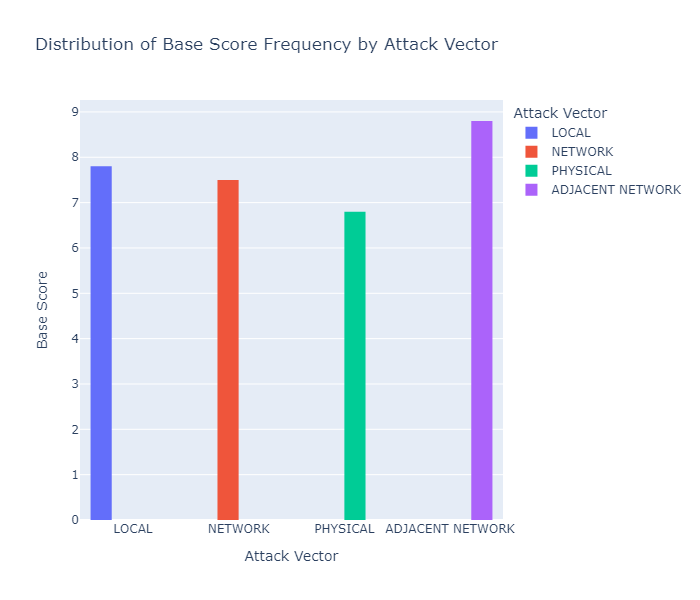

In [6]:

mode_df_base_score = dt_analyzer.calculate_mode_category(dataFrame, "attackVector", "baseScore", "Attack Vector", "Base Score")
dt_analyzer.show_histogram(mode_df_base_score, "Attack Vector", "Base Score", 700, 600, "Distribution of Base Score Frequency by Attack Vector", "png")



+----------------+------------------+
|   Attack Vector|        Base Score|
+----------------+------------------+
|           LOCAL|  6.64129519082938|
|         NETWORK| 7.354431876105042|
|        PHYSICAL| 5.635227303613316|
|ADJACENT NETWORK|7.1443182826042175|
+----------------+------------------+



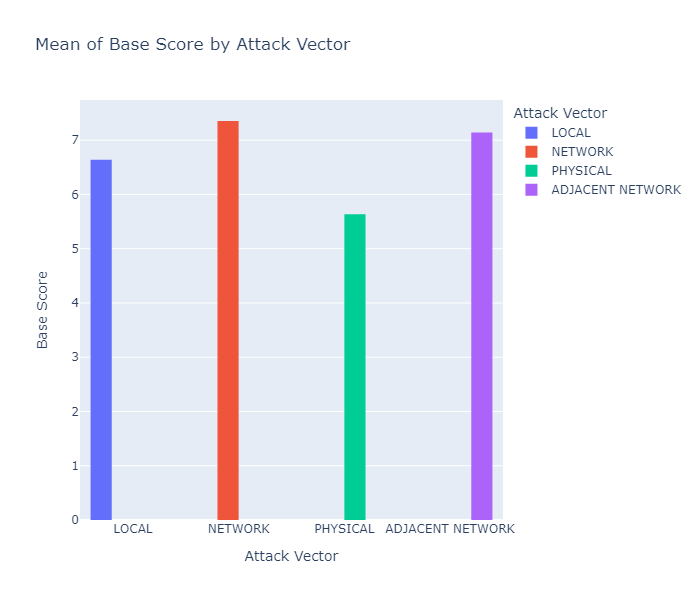

In [7]:
mean_df_base_score = dt_analyzer.calculate_mean_category(dataFrame, "attackVector", "baseScore", "Attack Vector", "Base Score")
dt_analyzer.show_histogram(mean_df_base_score, "Attack Vector", "Base Score", 700, 600, "Mean of Base Score by Attack Vector", "png")

The above results indicate that there is a higher distribution of vulnerabilites with higher severity from adjacent network. <br>
Thus for this sample the distribution is negatively skewed since the mode is greater than the mean

+----------------+------------+
|   Attack Vector|Impact Score|
+----------------+------------+
|           LOCAL|         5.9|
|         NETWORK|         5.9|
|        PHYSICAL|         5.9|
|ADJACENT NETWORK|         5.9|
+----------------+------------+



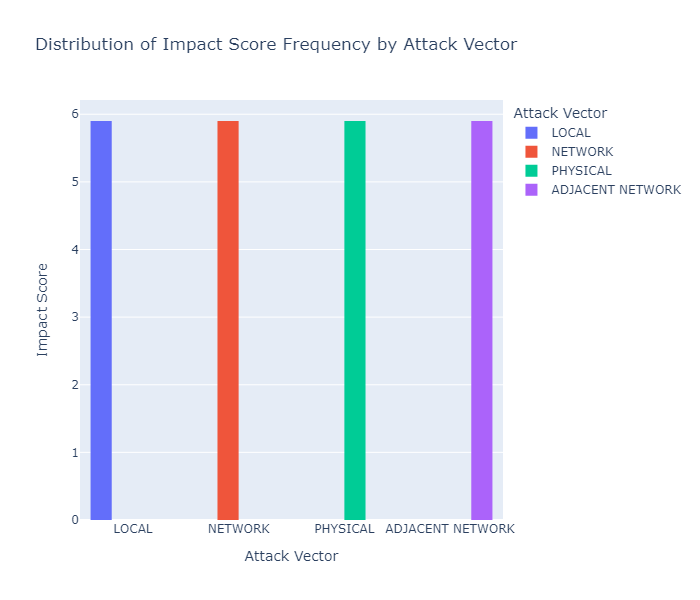

In [8]:
mode_df_impact_score = dt_analyzer.calculate_mode_category(dataFrame, "attackVector", "impactScore", "Attack Vector", "Impact Score")
dt_analyzer.show_histogram(mode_df_impact_score, "Attack Vector", "Impact Score", 700, 600, "Distribution of Impact Score Frequency by Attack Vector", "png")

+----------------+-----------------+
|   Attack Vector|     Impact Score|
+----------------+-----------------+
|           LOCAL|4.866454366412639|
|         NETWORK|4.125634429602993|
|        PHYSICAL|4.695454545996406|
|ADJACENT NETWORK|4.484090916135094|
+----------------+-----------------+



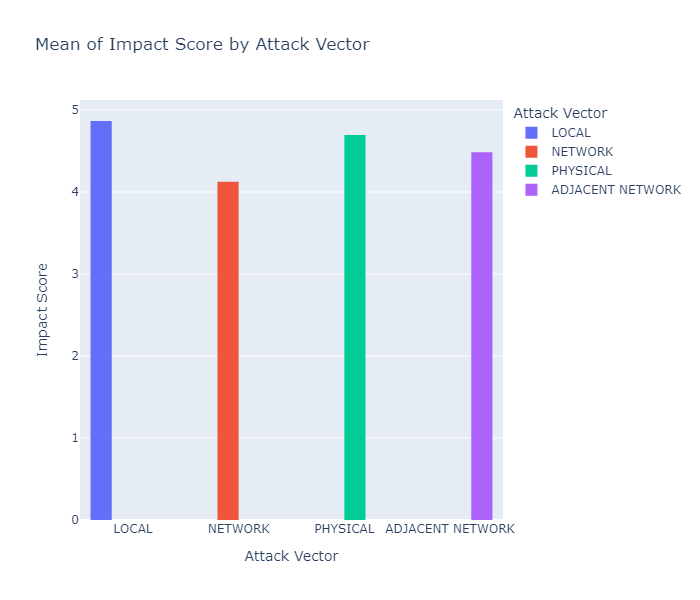

In [9]:
mean_df_impact_score = dt_analyzer.calculate_mean_category(dataFrame, "attackVector", "impactScore", "Attack Vector", "Impact Score")
dt_analyzer.show_histogram(mean_df_impact_score, "Attack Vector", "Impact Score", 700, 600, "Mean of Impact Score by Attack Vector", "png")

The mode(frequency) of the impact score by attack vector is observed to be constant with this sample.<br>
Thus the distribution of this sample for frequency of base score is uniform with no skewness.<br>
However, it is observed that the frequency for Impact Score is positively skewed based on the above histogram.

+----------------+--------------------+
|   Attack Vector|Exploitability Score|
+----------------+--------------------+
|           LOCAL|                 1.8|
|         NETWORK|                 3.9|
|        PHYSICAL|                 0.9|
|ADJACENT NETWORK|                 2.8|
+----------------+--------------------+



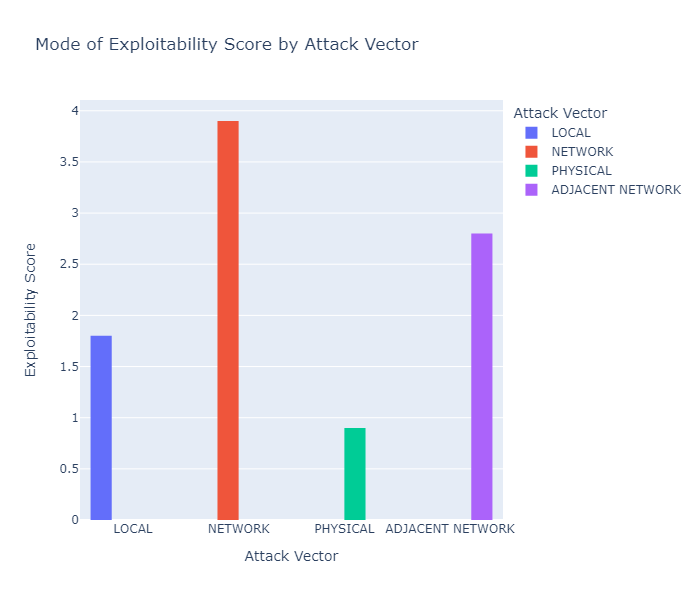

In [10]:
mode_df_exploitability_score = dt_analyzer.calculate_mode_category(dataFrame, "attackVector", "exploitabilityScore", "Attack Vector", "Exploitability Score")
dt_analyzer.show_histogram(mode_df_exploitability_score, "Attack Vector", "Exploitability Score", 700, 600, "Mode of Exploitability Score by Attack Vector", "png")

+----------------+--------------------+
|   Attack Vector|Exploitability Score|
+----------------+--------------------+
|           LOCAL|   1.657855589108862|
|         NETWORK|  3.0873115348570397|
|        PHYSICAL|  0.8295454347336834|
|ADJACENT NETWORK|   2.543181771581823|
+----------------+--------------------+



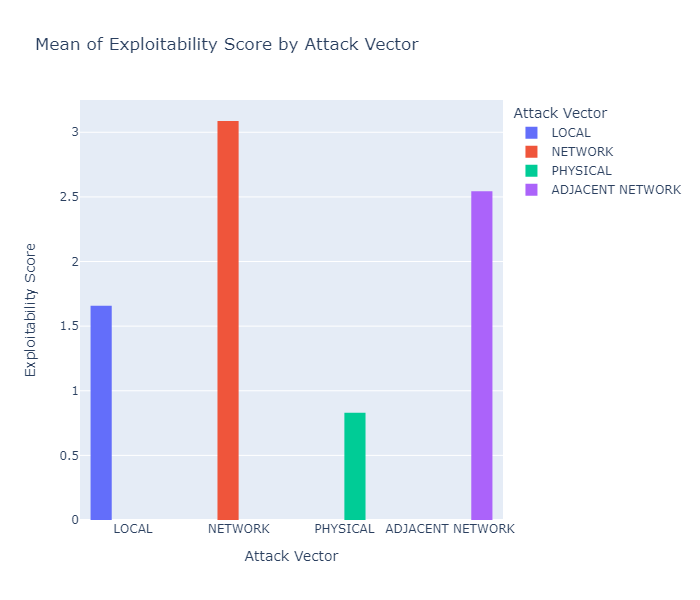

In [11]:
mean_df_exploitability_score = dt_analyzer.calculate_mean_category(dataFrame, "attackVector", "exploitabilityScore", "Attack Vector", "Exploitability Score")
dt_analyzer.show_histogram(mean_df_exploitability_score, "Attack Vector", "Exploitability Score", 700, 600, "Mean of Exploitability Score by Attack Vector", "png")

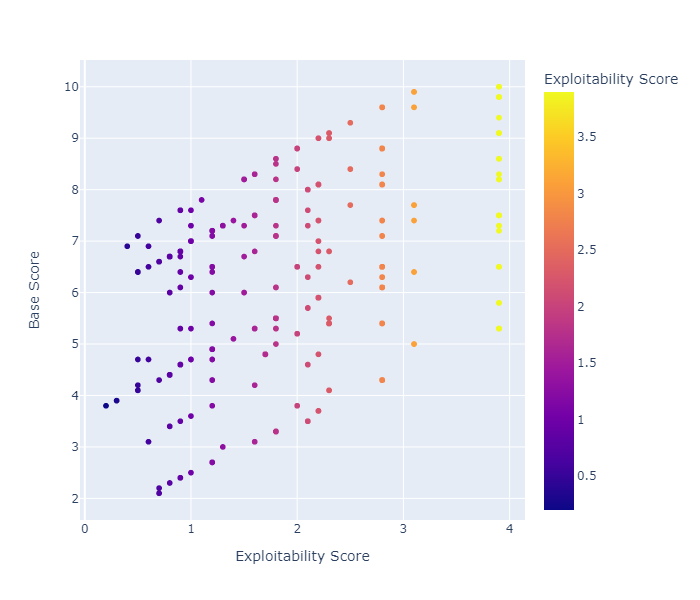

In [12]:
dt_analyzer.show_correlation_scatter_plot(processed_df, "exploitabilityScore", "baseScore", "Exploitability Score", "Base Score" , 700, 600, "", "png")

The above scatter plot indicates a low positive correlation between exploitability score and base score.<br>
Vulnerabilites with a higher exploitability and base score would effectively increase the overall CVSS score

+----------------+------------+-----+
|    attackVector|baseSeverity|count|
+----------------+------------+-----+
|ADJACENT_NETWORK|    CRITICAL|    1|
|         NETWORK|         LOW|   23|
|           LOCAL|        HIGH|  509|
|ADJACENT_NETWORK|        HIGH|   41|
|        PHYSICAL|         LOW|    9|
|           LOCAL|         LOW|   50|
|        PHYSICAL|      MEDIUM|   72|
|         NETWORK|        HIGH| 1079|
|         NETWORK|      MEDIUM| 1076|
|ADJACENT_NETWORK|         LOW|    2|
|         NETWORK|    CRITICAL|  541|
|           LOCAL|    CRITICAL|    1|
|           LOCAL|      MEDIUM|  382|
|        PHYSICAL|        HIGH|    7|
|ADJACENT_NETWORK|      MEDIUM|   44|
+----------------+------------+-----+



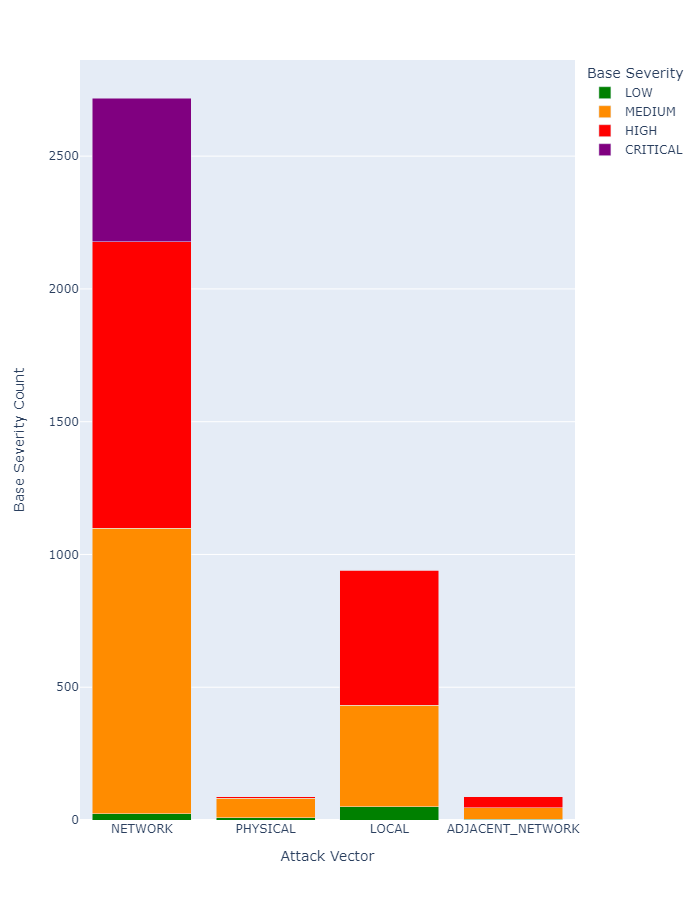

In [13]:
dt_analyzer.show_correlation_stacked_bar_chart(processed_df, "attackVector", "baseSeverity", "Attack Vector", "Base Severity" , 700, 900, "", "png")

For this sample, it can be observed that Network is the only attack vector having the most vulnerabilities with critical severity. <br>
In conclusion, Network is the most viable exploitable vector through which higher severity attacks can affect a system

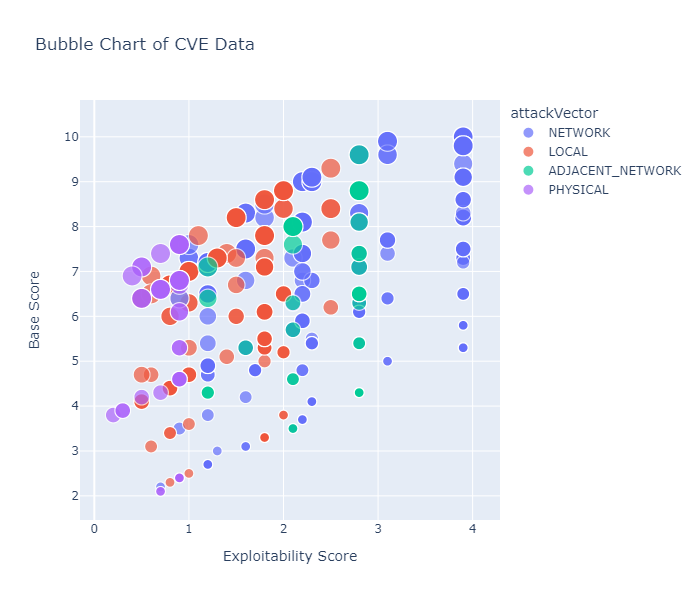

In [14]:
dt_analyzer.show_bubble_chart(processed_df, "exploitabilityScore", "baseScore", "Exploitability Score", "Base Score", "impactScore", "attackVector", 700, 600, "png")

The bubble chart above illustrates a low positive correlation between exploitability score and base score. <br>
However, an additional metric - Impact Score, has been introduced for extra dimensionality. <br>
Thus the size of the bubbles represent the value of the Impact Score giving an indication of which attack vector has the greatest exploit in a worse case scenario

0.7572788645793106
Correlation matrix:
                        Confidentiality Impact  Integrity Impact  \
Confidentiality Impact                1.000000          0.757279   
Integrity Impact                      0.757279          1.000000   
Availability Impact                   0.498010          0.606804   

                        Availability Impact  
Confidentiality Impact             0.498010  
Integrity Impact                   0.606804  
Availability Impact                1.000000  


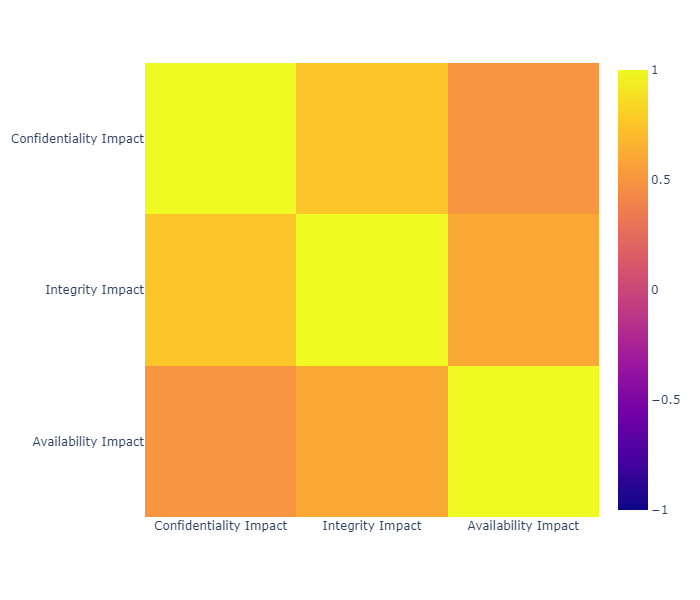

In [15]:
dt_analyzer.check_correlation(processed_df, "ConfidentialityImpactNumeric", "IntegrityImpactNumeric")
column_display_info = [
    {"column_name": "ConfidentialityImpactNumeric", "display_name": "Confidentiality Impact"},
    {"column_name": "IntegrityImpactNumeric", "display_name": "Integrity Impact"},
    {"column_name": "AvailabilityImpactNumeric", "display_name": "Availability Impact"}
]
correlation_df = dt_analyzer.calculate_correlation(processed_df, column_display_info)
dt_analyzer.show_heatmap(correlation_df, 700, 600, "", "png")

The above results indicate a low to strong positive correlation between Availability Impact, Confidentiality Impact and Integrity Impact. <br>
These scores are sub metrics used to calculate impact score, thus it can be indeed deduced that a slight increase in the sub metrics will affect the overall impact score. <br> 

0.8320470657436126
Correlation matrix:
              Base Score  Impact Score
Base Score      1.000000      0.832047
Impact Score    0.832047      1.000000


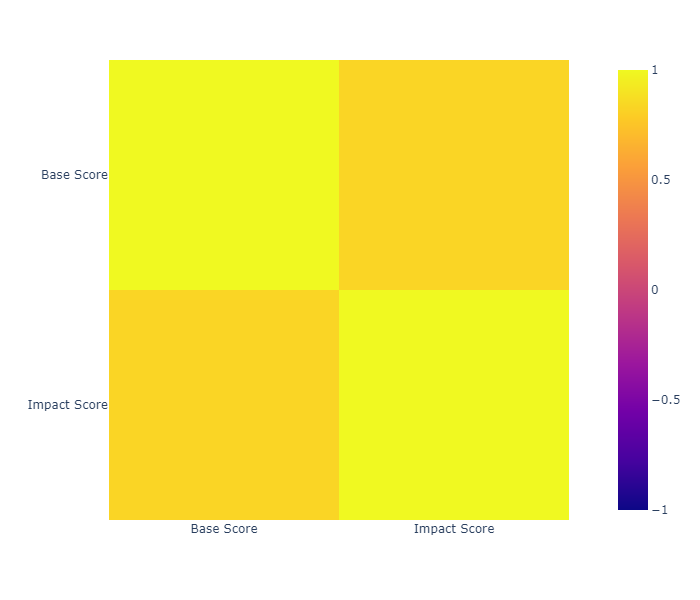

In [16]:
dt_analyzer.check_correlation(processed_df, "baseScore", "impactScore")
columns = [
    {"column_name": "baseScore", "display_name": "Base Score"},
    {"column_name": "impactScore", "display_name": "Impact Score"},
]

correlation_df_score = dt_analyzer.calculate_correlation(processed_df, columns)
dt_analyzer.show_heatmap(correlation_df_score, 700, 600, "", "png")

The base score and impact score are both used to calculate the overall CVSS score. <br>
The above heatmap illustrates a strong correlation between base and impact score. <br>
Thus, an increase in base score can affect the impact score which can cause the overall CVSS score to deviate into a higher severity range